# Lab 1: Design a TRL Kit with ANSYS and Verify in Python

This lab will follow a similar procedure to that in the pre lab to design a TRL calibration kit.

### Design

TRL calibration kits require 3 standards of different lengths of transmission lines: a through of arbitrary length, a reflect that is half of the length of the through that is terminated in an open circuit, and a line, which is a quarter wavelength longer than the through.

This kit will be made using microstrip transmission lines in ANSYS Electronics as a cricuit model. The .snp files will be exported for each standard, and analyzed using scikit-rf in Python.

### ANSYS Electronics Circuit Model

![Fig1.png](Fig1.png)

In this design, the dimensions of the microstrip line were parameterized. The operating frequency bandwidth was arbitrarily chosen to be 2-6 GHz, resulting in a center frequency of 4.25 GHz (geometric mean). and the substrate is 62 mil FR4. The widths of the lines were determined by using the TRL properties as shown in the pre lab. The length of the through line was chosen to be 40 mm, so that connectors could be soldered on when the design is fabricated.

* Note: The open circuit stub for the reflect standard is listed in ANSYS as MS Open Stub, Physical Length. Simply assign the same width to this model and attach it to one end of the reflect.

* Note: Best design practice would be to break these three standards up into separate circuit simulations. They are included together in this example for berevity.

To parameterize the lines, simply type in a variable name where it asks for a value and you can assign a value to the variable. For this design, the parameters are given below.

![Fig2.png](Fig2.png)

### Analysis

Setup a linear frequency sweep as demonstrated in the pre lab. Sweep the frequency across the chosen bandwidth, and run the analysis. Export the .snp files. We will import these into a Python script and verify that the design works using scikit-rf (SKRF).


### Scikit-RF

In [14]:
# Import dependencies

import skrf as rf
from matplotlib import pyplot as plt
from skrf.calibration import OnePort
from skrf.calibration.calibration import TRL
from skrf import data
import numpy as np

# import the .snp
# This is a 5 port matrix b/c the thru/line/reflect were made on same ckt
# best practice is to separate these files to get .s2p files for each
ntwk = rf.Network('Project1_Circuit1.s5p')

S = ntwk.s

#keep it complex
thru_S = 1j*np.ones((1000,2,2))
line_S = 1j*np.ones((1000,2,2))

thru_S[:,0,0] = S[:,0,0]
thru_S[:,0,1] = S[:,0,1]
thru_S[:,1,0] = S[:,1,0]
thru_S[:,1,1] = S[:,1,1]

line_S[:,0,0] = S[:,2,2]
line_S[:,0,1] = S[:,2,3]
line_S[:,1,0] = S[:,3,2]
line_S[:,1,1] = S[:,3,3]

freq = rf.Frequency(2,6,1000,'ghz')

thru = rf.Network(name='Thru', frequency=freq, s=thru_S, z0=[ 50, 50 ])
line = rf.Network(name='Line', frequency=freq, s=line_S, z0=[ 50, 50 ])

# this step is necessary even if you separate the simulation files
### reflect should be a .s1p file, but skrf wants it as a .s2p file for the TRL calibration
refl_S = 1j*np.zeros((1000,2,2)) 
refl_S[:,0,0] = S[:,4,4]
refl = rf.Network(name='Refl', frequency=freq, s=refl_S, z0=[ 50, 50 ])

print("Thru: ", thru, "\n")
print("Line: ", line, "\n")
print("Reflect: ", refl, "\n")

Thru:  2-Port Network: 'Thru',  2-6 GHz, 1000 pts, z0=[50.+0.j 50.+0.j] 

Line:  2-Port Network: 'Line',  2-6 GHz, 1000 pts, z0=[50.+0.j 50.+0.j] 

Reflect:  2-Port Network: 'Refl',  2-6 GHz, 1000 pts, z0=[50.+0.j 50.+0.j] 



*Note that if the simulations were done individually that rf.Network would only need to be called once per standard, except for the reflect standard. SKRF wants two-port networks for each standard in the TRL calibration, so we add complex zeros fill out the two-port reflect standard.

In [19]:
measured = [thru, refl, line]

trl = TRL(measured=measured)

C:\ProgramData\Anaconda3\lib\site-packages\skrf\calibration\calibration.py:2017: UserWarning: No switch terms provided
  warn('No switch terms provided')


Don't mind the warning about switching terms-- they aren't necessary.

Next we will verify that our TRL kit works as expected by verifying that there is a 90 degree shift in the line standard. This should be the case since we designed it to be a quarter wavelength longer than the through standard.

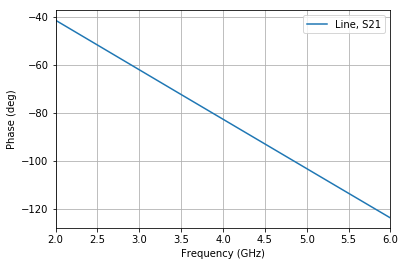

In [18]:
dut_L = trl.apply_cal(line)
dut_L.s12.plot_s_deg(label='Line, S21')
plt.grid() #turn this on to see if we hit 90 degrees at the center frequency
plt.show()

We can observe that the TRL calibration was a success because the line standard provided a 90 degree phase shift at the center frequency, 4.25 GHz.

As a sanity check, we will also plot the phase of the through standard to make sure there is no phase shift there.

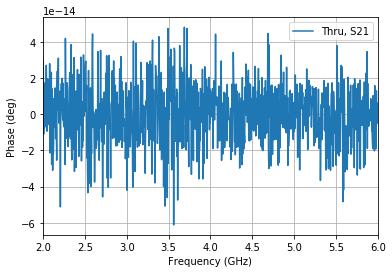

In [17]:
dut_T = trl.apply_cal(thru)
dut_T.s12.plot_s_deg(label='Thru, S21')
plt.grid()
plt.show()

### Conclusion

In this lab, we successfully demonstrated how to create a TRL kit model using ANSYS Electronics. The performance of this model was verified by using the TRL calibration functionality of scikit-rf. The phase plots of the calibrated line and through standards confirmed that the kit worked as expected.